# 注意力评分函数

In [3]:
import torch
import math
from d2l import torch as d2l
from torch import nn

In [4]:
def masked_softmax(X, valid_lens):
    """
    带掩码的softmax函数，用于注意力机制中处理变长序列
    
    参数:
        X: 输入张量，形状通常是 (batch_size, num_queries, num_keys) 或 (batch_size, num_keys)
           表示注意力分数（attention scores）
        valid_lens: 有效长度，可以是：
            - None: 不进行掩码，直接计算softmax
            - 1维张量: 形状为 (batch_size,)，每个元素表示对应样本的有效长度
            - 2维张量: 形状为 (batch_size, num_queries)，每个查询位置的有效长度
    
    返回:
        经过掩码和softmax处理后的注意力权重
    
    工作原理:
        1. 如果 valid_lens 为 None，直接计算softmax
        2. 否则，将超出有效长度的位置设置为 -1e6（一个很小的负数）
        3. 然后计算softmax，这样被掩码的位置经过softmax后会接近0
    """
    # 情况1: 如果没有提供有效长度，直接计算softmax
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        # 保存原始形状，因为后面需要reshape回来
        shape = X.shape
        
        # 情况2: valid_lens 是1维张量，形状为 (batch_size,)
        # 例如: valid_lens = [2, 3] 表示第一个样本有效长度为2，第二个为3
        if valid_lens.dim() == 1:
            # 需要将每个样本的有效长度重复 shape[1] 次
            # 例如: 如果 X.shape = (2, 4, 5)，shape[1] = 4
            # valid_lens = [2, 3] -> [2,2,2,2, 3,3,3,3] (每个重复4次)
            # 这样每个查询位置都能知道对应的有效长度
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            # 情况3: valid_lens 是2维张量，形状为 (batch_size, num_queries)
            # 直接展平成一维
            valid_lens = valid_lens.reshape(-1)
        
        # 将 X reshape 成 (batch_size * num_queries, num_keys) 的形状
        # 这样每一行对应一个查询位置
        # 使用 sequence_mask 将超出有效长度的位置设置为 -1e6
        # -1e6 是一个很小的负数，经过softmax后会接近0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        
        # 将 X reshape 回原始形状，然后计算softmax
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [5]:
masked_softmax(torch.rand(2,2,4), torch.tensor([2,3]))

tensor([[[0.4494, 0.5506, 0.0000, 0.0000],
         [0.4606, 0.5394, 0.0000, 0.0000]],

        [[0.2962, 0.4008, 0.3030, 0.0000],
         [0.4542, 0.3134, 0.2324, 0.0000]]])

In [6]:
masked_softmax(torch.rand(2,2,4), torch.tensor([[1,3],[2,4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4930, 0.2375, 0.2695, 0.0000]],

        [[0.5384, 0.4616, 0.0000, 0.0000],
         [0.2182, 0.2770, 0.3070, 0.1978]]])

In [8]:
class AdditiveAttention(nn.Module):
    """
    加性注意力（Additive Attention），也称为 Bahdanau Attention
    
    工作原理：
    1. 将 queries 和 keys 分别通过线性层映射到相同维度 num_hiddens
    2. 对每个 (query, key) 对计算特征：features = tanh(W_q(q) + W_k(k))
    3. 通过另一个线性层得到注意力分数
    4. 使用 softmax 归一化得到注意力权重
    5. 用注意力权重对 values 进行加权求和
    """
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs) -> None:
        super().__init__()
        # W_k: 将 keys 从 key_size 维映射到 num_hiddens 维
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        # W_q: 将 queries 从 query_size 维映射到 num_hiddens 维
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        # W_v: 将特征从 num_hiddens 维映射到 1 维（得到标量分数）
        self.W_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens):
        """
        前向传播
        
        参数:
            queries: 形状 (batch_size, num_queries, query_size)
            keys: 形状 (batch_size, num_keys, key_size)
            values: 形状 (batch_size, num_keys, value_size)
            valid_lens: 有效长度，用于掩码
        
        返回:
            加权后的 values，形状 (batch_size, num_queries, value_size)
        """
        # 步骤1: 将 queries 和 keys 映射到相同维度 num_hiddens
        # queries: (batch_size, num_queries, query_size) -> (batch_size, num_queries, num_hiddens)
        # keys: (batch_size, num_keys, key_size) -> (batch_size, num_keys, num_hiddens)
        queries, keys = self.W_q(queries), self.W_k(keys)
        
        # 步骤2: 计算所有 (query, key) 对的加性特征
        # 这是加性注意力的核心：features = queries + keys（经过广播）
        #
        # 详细解释 unsqueeze 和广播机制：
        # queries: (batch_size, num_queries, num_hiddens)
        #   unsqueeze(2) -> (batch_size, num_queries, 1, num_hiddens)
        #   在第2维（索引为2）插入一个新维度
        #
        # keys: (batch_size, num_keys, num_hiddens)
        #   unsqueeze(1) -> (batch_size, 1, num_keys, num_hiddens)
        #   在第1维（索引为1）插入一个新维度
        #
        # 广播机制：
        # queries: (batch_size, num_queries, 1, num_hiddens)
        # keys:    (batch_size, 1, num_keys, num_hiddens)
        # 相加后:   (batch_size, num_queries, num_keys, num_hiddens)
        #
        # 这意味着：对于每个 query，我们计算它与所有 keys 的组合特征
        # features[i, j, k, :] = queries[i, j, :] + keys[i, k, :]
        # 即：第 i 个样本的第 j 个 query 与第 k 个 key 的组合特征
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        # features 形状: (batch_size, num_queries, num_keys, num_hiddens)
        
        # 步骤3: 通过 tanh 激活函数
        features = torch.tanh(features)
        
        # 步骤4: 通过 W_v 得到注意力分数（标量）
        # features: (batch_size, num_queries, num_keys, num_hiddens)
        # W_v(features): (batch_size, num_queries, num_keys, 1)
        # squeeze(-1): (batch_size, num_queries, num_keys)
        scores = self.W_v(features).squeeze(-1)
        # scores[i, j, k] 表示第 i 个样本的第 j 个 query 对第 k 个 key 的注意力分数
        
        # 步骤5: 使用 masked_softmax 归一化得到注意力权重
        self.attention_weights = masked_softmax(scores, valid_lens)
        # attention_weights 形状: (batch_size, num_queries, num_keys)
        # 每一行的和等于1（经过softmax归一化）
        
        # 步骤6: 使用注意力权重对 values 进行加权求和
        # dropout 用于防止过拟合
        # bmm: batch matrix multiplication
        # dropout(attention_weights): (batch_size, num_queries, num_keys)
        # values: (batch_size, num_keys, value_size)
        # 结果: (batch_size, num_queries, value_size)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [9]:

# ========== 测试 AdditiveAttention 的示例代码 ==========

# 步骤1: 创建 queries（查询向量）
# torch.normal(0, 1, (2, 1, 20)) 表示：
#   - 从均值为0、标准差为1的正态分布中采样
#   - 形状为 (batch_size=2, num_queries=1, query_size=20)
#   - 即：2个样本，每个样本有1个查询，每个查询是20维向量
queries, keys = torch.normal(0,1,(2,1,20)), torch.ones((2,10,2))
# queries.shape = (2, 1, 20)
# keys.shape = (2, 10, 2)
#   - torch.ones((2, 10, 2)) 创建全1张量
#   - 形状为 (batch_size=2, num_keys=10, key_size=2)
#   - 即：2个样本，每个样本有10个键，每个键是2维向量

# 步骤2: 创建 values（值向量）
# torch.arange(40) 创建 [0, 1, 2, ..., 39] 共40个数
# reshape(1, 10, 4) 重塑为 (1, 10, 4)，即1个样本，10个值，每个值4维
# repeat(2, 1, 1) 在第0维重复2次，得到 (2, 10, 4)
#   - 即：2个样本，每个样本有10个值，每个值是4维向量
values = torch.arange(40, dtype=torch.float32).reshape(1,10,4).repeat(2,1,1)
print(f"values.shape = {values.shape}")  # 输出: torch.Size([2, 10, 4])

# 步骤3: 设置有效长度（用于掩码）
# valid_lens = [2, 6] 表示：
#   - 第1个样本的有效长度为2（只关注前2个keys）
#   - 第2个样本的有效长度为6（只关注前6个keys）
#   - 超出有效长度的位置会被掩码（设置为很小的值，softmax后接近0）
valid_lens = torch.tensor([2,6])

# 步骤4: 创建 AdditiveAttention 模块
# 参数说明：
#   - key_size=2: keys的维度是2
#   - query_size=20: queries的维度是20
#   - num_hiddens=8: 隐藏层维度是8（queries和keys都会被映射到这个维度）
#   - dropout=0.1: dropout概率为0.1（用于防止过拟合）
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)

# 步骤5: 设置为评估模式
# eval() 模式会：
#   - 关闭dropout（在推理时不需要随机丢弃）
#   - 关闭batch normalization的更新
#   - 但注意：这里dropout仍然会在forward中被调用，只是eval()模式下dropout会失效
attention.eval()

# 步骤6: 执行前向传播
# 输入：
#   - queries: (2, 1, 20) - 2个样本，每个1个查询，20维
#   - keys: (2, 10, 2) - 2个样本，每个10个键，2维
#   - values: (2, 10, 4) - 2个样本，每个10个值，4维
#   - valid_lens: [2, 6] - 有效长度
#
# 处理过程：
#   1. queries通过W_q映射: (2, 1, 20) -> (2, 1, 8)
#   2. keys通过W_k映射: (2, 10, 2) -> (2, 10, 8)
#   3. 计算features: (2, 1, 10, 8) - 每个query与所有keys的组合
#   4. 计算scores: (2, 1, 10) - 注意力分数
#   5. masked_softmax得到权重: (2, 1, 10) - 注意力权重（每行和为1）
#   6. 加权求和values: (2, 1, 4) - 最终输出
#
# 输出：
#   - 形状: (2, 1, 4) - 2个样本，每个1个查询对应的加权值，4维
result = attention(queries, keys, values, valid_lens)
print(f"\n输出形状: {result.shape}")  # torch.Size([2, 1, 4])
print(f"\n注意力权重形状: {attention.attention_weights.shape}")  # torch.Size([2, 1, 10])
print(f"\n注意力权重:\n{attention.attention_weights}")
print("\n解释:")
print("- 第1个样本: 只关注前2个keys（有效长度=2），所以前2个权重较大，后8个接近0")
print("- 第2个样本: 只关注前6个keys（有效长度=6），所以前6个权重较大，后4个接近0")


values.shape = torch.Size([2, 10, 4])

输出形状: torch.Size([2, 1, 4])

注意力权重形状: torch.Size([2, 1, 10])

注意力权重:
tensor([[[0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000,
          0.0000, 0.0000]]], grad_fn=<SoftmaxBackward0>)

解释:
- 第1个样本: 只关注前2个keys（有效长度=2），所以前2个权重较大，后8个接近0
- 第2个样本: 只关注前6个keys（有效长度=6），所以前6个权重较大，后4个接近0


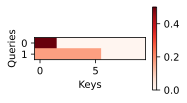

In [10]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')


In [11]:
class DotProductAttention(nn.Module):
    def __init__(self, dropout) -> None:
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_len=None):
        d = queries.shape[-1]
        scores = torch.bmm(queries,keys.transpose(1,2))/math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [12]:
queries = torch.normal(0,1,(2,1,2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

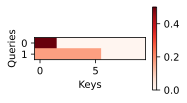

In [13]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')